# Segmentation of Indian Traffic

In [1]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [4]:
import zipfile
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
file_list = os.listdir('data')
file_list

['images', 'mask']

In [2]:
file_list = os.listdir('data/images/')
len(file_list)

143

In [3]:
file_list = os.listdir('data/mask/201')
file_list

['frame0029_gtFine_polygons.json',
 'frame0299_gtFine_polygons.json',
 'frame0779_gtFine_polygons.json',
 'frame1019_gtFine_polygons.json',
 'frame1469_gtFine_polygons.json',
 'frame1979_gtFine_polygons.json',
 'frame2519_gtFine_polygons.json',
 'frame2819_gtFine_polygons.json',
 'frame3179_gtFine_polygons.json',
 'frame3749_gtFine_polygons.json',
 'frame4079_gtFine_polygons.json']

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [4]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    data_df = pd.DataFrame()

    image_path = []
    file_path = root_dir + '/images/'
    file_list = os.listdir(file_path)
        
    for i in range(len(file_list)):
        inner_folder = os.listdir(file_path+file_list[i])
        for j in inner_folder:
            image_path.append(file_path+file_list[i]+'/'+j)
    data_df['images'] = image_path
    
    json_path = []       
    mask_path = root_dir + '/mask/'
    mask_list = os.listdir(mask_path)
    
    for i in range(len(mask_list)):
        inner_folder = os.listdir(mask_path+mask_list[i])
        for j in inner_folder:
            json_path.append(mask_path+mask_list[i]+'/'+j)
    
    data_df['json'] = json_path
    
    return data_df

In [5]:
data_df = return_file_names_df('data')
data_df.head()

images  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  
0  data/mask/201/frame0029_gtFine_polygons.json  
1  data/mask/201/frame0299_gtFine_polygons.json  
2  data/mask/201/frame0779_gtFine_polygons.json  
3  data/mask/201/frame1019_gtFine_polygons.json  
4  data/mask/201/frame1469_gtFine_polygons.json

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [10]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it
    unique_labels = set()
    for i in data_df['json']:
        f = open(i)
        data = json.load(f)
        for j in range(len(data['objects'])):
            label = data['objects'][j]['label']
            unique_labels.add(label)
    return unique_labels

In [11]:
unique_labels = return_unique_labels(data_df)

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [1]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [13]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [6]:
def get_poly(file):
    # this function will take a file name as argument
    
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image
    
    label = []
    vertexlist = []
    
    f = open(file)
    data = json.load(f)
    for i in range(len(data['objects'])):
        unique_label = data['objects'][i]['label']
        vertex = data['objects'][i]['polygon'] 
        label.append(unique_label)
        vertex1 = []
        for j in vertex:
            vertex1.append(tuple(j))
        vertexlist.append(vertex1)
        w = data['imgWidth']
        h = data['imgHeight']
    
    return w, h, label, vertexlist

## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

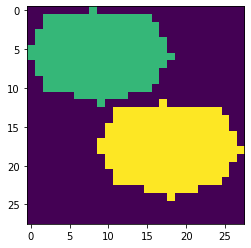

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [8]:
import os
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    
    path_ = []
    for i in data_df['json']:
        w, h, labels, vertexlist = get_poly(i)
        
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for j in range(len(vertexlist)):
            if len(vertexlist[j])<=1:
                pass
            else:
                img1.polygon(vertexlist[j], fill = label_clr[labels[j]])
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        path = os.path.isdir("data/output/" + i.split('/')[2])
        if path==False:
            os.makedirs("data/output/" + i.split('/')[2])
        im.save("data/output/" + i.split('/')[2] + "/" + i.split('/')[-1].split('.')[0] + ".png")
        path_.append("data/output/" + i.split('/')[2] + "/" + i.split('/')[-1].split('.')[0] + ".png")
    data_df['mask'] = path_
    return data_df

In [174]:
data_df = compute_masks(data_df)
data_df.head()

images  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame0029_gtFine_polygons.json   
1  data/mask/201/frame0299_gtFine_polygons.json   
2  data/mask/201/frame0779_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame1469_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame0029_gtFine_polygons.png  
1  data/output/201/frame0299_gtFine_polygons.png  
2  data/output/201/frame0779_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame1469_gtFine_polygons.png

In [176]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

#### Dice Loss
Dice Coefficient = 2 * intersection / union + intersection <br>
i.e., `Dice Coefficient = 2TP / 2TP + FP + FN` <br>
1. Here, we can see this is similar to iou, but here we take 2 times of TP <br>
2. this is a measure of overlap between two images ranges from 0 to 1. If both input mask and output mask overlap better (means predicted output mask is good) then this value will be more near to 1, if not then ore near to 0 <br>
3. In the numerator we take overlap between two mask locally and in denominator we take overall boundary globally.
4. so it helps in calculating difference between actual and predicted mask well <br>

`Dice loss = 1 - Dice Coefficient`, where we need loss as close to 0


### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [2]:
data_df = pd.read_csv('preprocessed_data.csv')
data_df

images  \
0      data/images/201/frame0029_leftImg8bit.jpg   
1      data/images/201/frame0299_leftImg8bit.jpg   
2      data/images/201/frame0779_leftImg8bit.jpg   
3      data/images/201/frame1019_leftImg8bit.jpg   
4      data/images/201/frame1469_leftImg8bit.jpg   
...                                          ...   
4003  data/images/429/frame13262_leftImg8bit.jpg   
4004  data/images/429/frame13699_leftImg8bit.jpg   
4005  data/images/429/frame15812_leftImg8bit.jpg   
4006  data/images/429/frame18062_leftImg8bit.jpg   
4007  data/images/429/frame18403_leftImg8bit.jpg   

                                               json  \
0      data/mask/201/frame0029_gtFine_polygons.json   
1      data/mask/201/frame0299_gtFine_polygons.json   
2      data/mask/201/frame0779_gtFine_polygons.json   
3      data/mask/201/frame1019_gtFine_polygons.json   
4      data/mask/201/frame1469_gtFine_polygons.json   
...                                             ...   
4003  data/mask/429/frame13262_gtFine_polygons.json   
4004  data/mask/429/frame13699_gtFine_polygons.json   
4005  data/mask/429/frame15812_gtFine_polygons.json   
4006  data/mask/429/frame18062_gtFine_polygons.json   
4007  data/mask/429/frame18403_gtFine_polygons.json   

                                                mask  
0      data/output/201/frame0029_gtFine_polygons.png  
1      data/output/201/frame0299_gtFine_polygons.png  
2      data/output/201/frame0779_gtFine_polygons.png  
3      data/output/201/frame1019_gtFine_polygons.png  
4      data/output/201/frame1469_gtFine_polygons.png  
...                                              ...  
4003  data/output/429/frame13262_gtFine_polygons.png  
4004  data/output/429/frame13699_gtFine_polygons.png  
4005  data/output/429/frame15812_gtFine_polygons.png  
4006  data/output/429/frame18062_gtFine_polygons.png  
4007  data/output/429/frame18403_gtFine_polygons.png  

[4008 rows x 3 columns]

In [3]:
# train test split

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(data_df, test_size=0.15, random_state=45)

In [4]:
!pip install git+https://github.com/qubvel/segmentation_models

In [4]:
import tensorflow as tf
import keras
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')
import imgaug.augmenters as iaa

Segmentation Models: using `keras` framework.


In [5]:
sm.__version__

'1.0.1'

In [6]:
aug1 = iaa.Fliplr(1)
aug2 = iaa.Emboss(alpha=(1), strength=1)
aug3 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

### Generating input image and mask image and batch

In [7]:
class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    
    def __init__(self, images_dir, label_clr, file_names):
        
        # the paths of images
        self.image = images_dir['images'].values
        # the paths of segmentation images
        self.mask_image = images_dir['mask'].values
        self.classes = list(set(label_clr.values()))
        self.ids = file_names
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.image[i], cv2.IMREAD_UNCHANGED)
        mask  = cv2.imread(self.mask_image[i], cv2.IMREAD_UNCHANGED)
        #mask = normalize_image(mask)

        #resizing both the images
        input_image = cv2.resize(image, (512, 512), interpolation=cv2.INTER_NEAREST)
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        mask_image = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)
        
        #one hot encoding mask
        mask_image = [(mask_image == v) for v in self.classes]
        mask_image = np.stack(mask_image, axis=-1).astype('float')
   
        a = np.random.uniform()
        if a<0.25:
            input_image = aug1.augment_image(input_image)
            mask_image = aug1.augment_image(mask_image)
        elif a<0.50:
            input_image = aug2.augment_image(input_image)
            mask_image = aug2.augment_image(mask_image)
        elif a<0.75:
            input_image = aug3.augment_image(input_image)
            mask_image = aug3.augment_image(mask_image)
        else:
            input_image = aug4.augment_image(input_image)
            mask_image = aug4.augment_image(mask_image)
            
        
        return input_image, mask_image
        
    def __len__(self):
        return len(self.ids)
    


In [8]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
    
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
    
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [9]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

#batch size = 3

train_file_names = X_train.images.values
test_file_names = X_test.images.values
train_dataset = Dataset(X_train, label_clr, train_file_names)
test_dataset  = Dataset(X_test, label_clr, test_file_names)

train_dataloader = Dataloder(train_dataset, batch_size=3, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=3, shuffle=True)

In [14]:
train_dataloader[0][0].shape

(3, 512, 512, 3)

In [15]:
train_dataloader[0][1].shape

(3, 512, 512, 21)

### checking sample input image and mask image

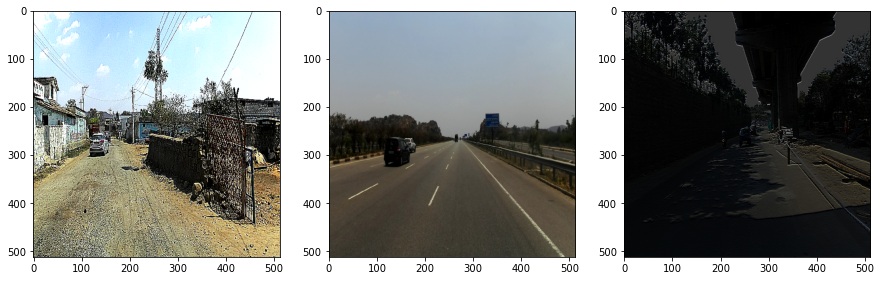

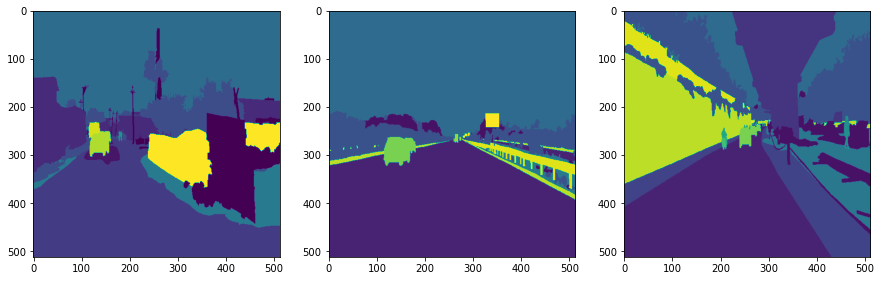

In [16]:
# batch 1

image, mask_image = train_dataloader[0]
plt.figure(figsize=(15, 7))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(image[i])
plt.figure(figsize=(15, 7))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(np.argmax(mask_image[i], axis=-1))

## Training unet model and using the resnet 34

In [17]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(512,512,3), encoder_freeze = True)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [1]:
%load_ext tensorboard

In [20]:
import datetime

In [21]:
!rm -rf ./logs/unet/

In [22]:
log_dir="logs/unet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0, write_graph=True,write_grads=True)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_iou_score', filepath = 'unetmodel.h5', save_best_only = True)

In [23]:
callbacks = [tensorboard_callback,modelcheckpoint]

In [11]:
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.0001)

focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
#total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, focal_loss, metrics=[iou_score])

In [29]:
model.fit_generator(train_dataloader, validation_data = test_dataloader, epochs = 50, steps_per_epoch = len(train_dataloader), callbacks = callbacks)

C:\Users\paart\apps\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\paart\apps\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/50
1135/1135 [==============================] - 708s 614ms/step - loss: 0.8643 - iou_score: 0.1397 - val_loss: 0.7561 - val_iou_score: 0.2176
Epoch 2/50
1135/1135 [==============================] - 671s 591ms/step - loss: 0.7206 - iou_score: 0.2448 - val_loss: 0.6800 - val_iou_score: 0.2793
Epoch 3/50
1135/1135 [==============================] - 764s 674ms/step - loss: 0.6697 - iou_score: 0.2886 - val_loss: 0.6504 - val_iou_score: 0.3046
Epoch 4/50
1135/1135 [==============================] - 814s 717ms/step - loss: 0.6581 - iou_score: 0.3006 - val_loss: 0.6380 - val_iou_score: 0.3216
Epoch 5/50
1135/1135 [==============================] - 752s 663ms/step - loss: 0.6358 - iou_score: 0.3218 - val_loss: 0.6196 - val_iou_score: 0.3394
Epoch 6/50
1135/1135 [==============================] - 729s 642ms/step - loss: 0.6231 - iou_score: 0.3328 - val_loss: 0.6234 - val_iou_score: 0.3309
Epoch 7/50
1135/1135 [==============================] - 708s 623ms/step - loss: 0.6119 - iou_score: 

In [ ]:
%tensorboard --logdir="C:\Users\paart\segmentation\logs\unet\20220813-123342"

`I haven't added graph for loss and iou, as my tensorboard couldn't load at that time. I tried it through cmd also, it is not loading, but the data is available inside that mentioned path`

In [10]:
# loading custom model

focal_loss = sm.losses.cce_dice_loss

from keras.models import load_model
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({'categorical_crossentropy_plus_dice_loss': focal_loss, 'iou_score':iou_score})

model = load_model('unetmodel.h5')

### Predicting on test data

<ipython-input-13-27c68221b52d>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, i + 1)


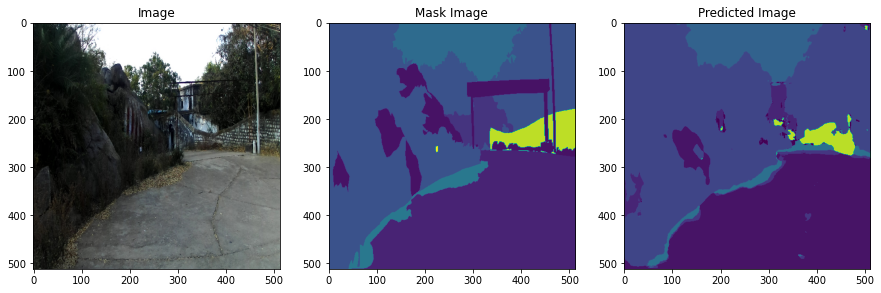

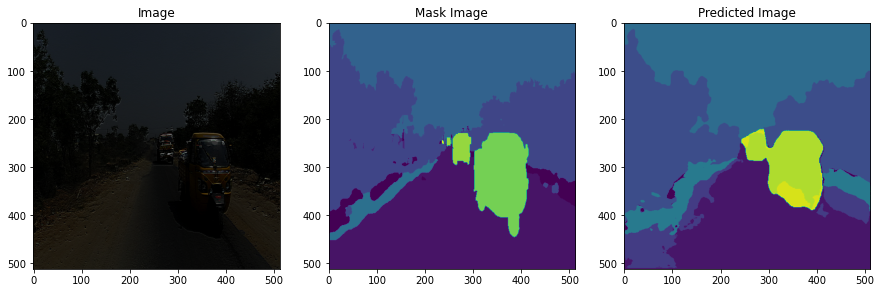

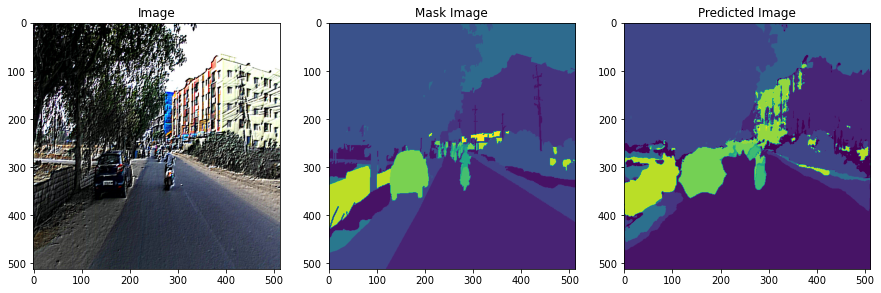

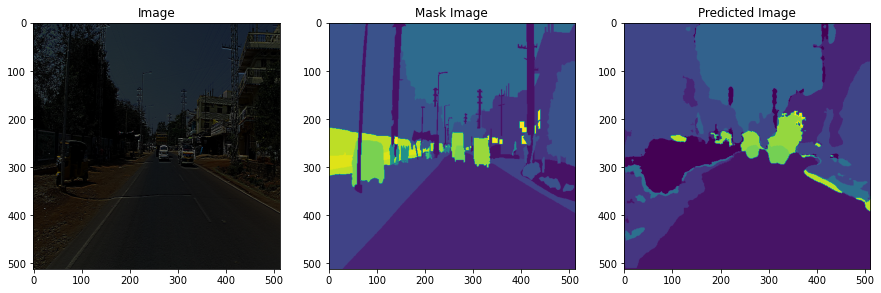

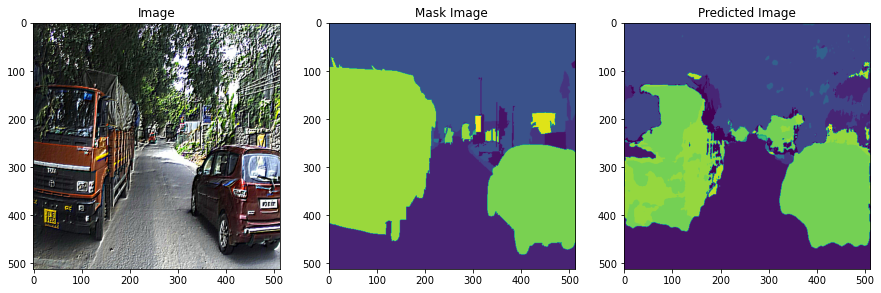

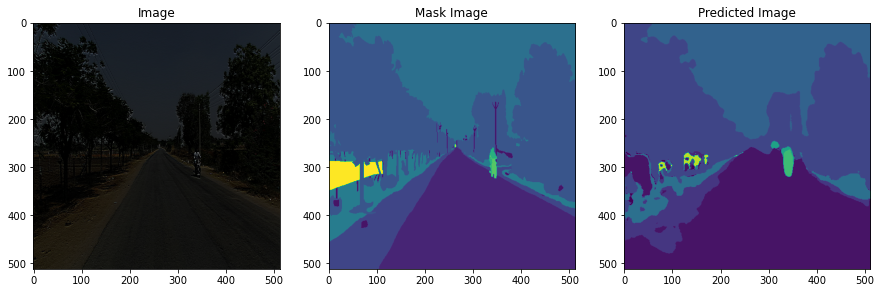

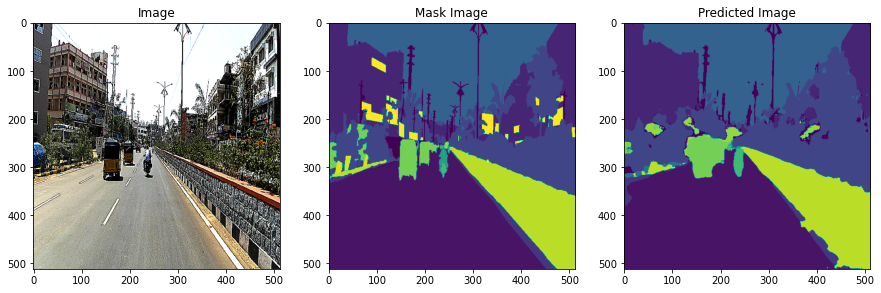

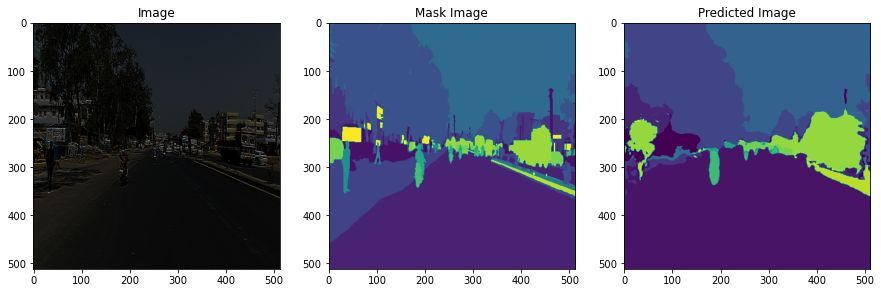

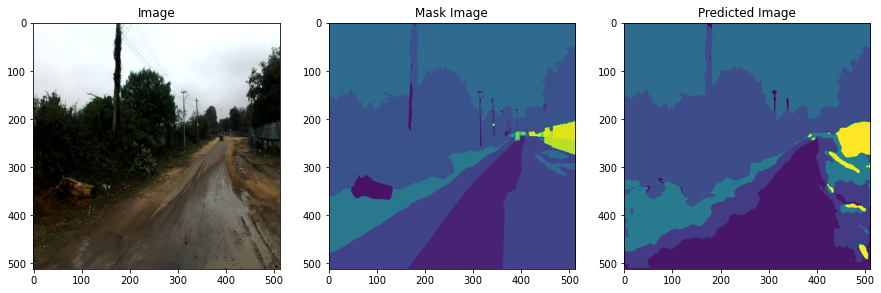

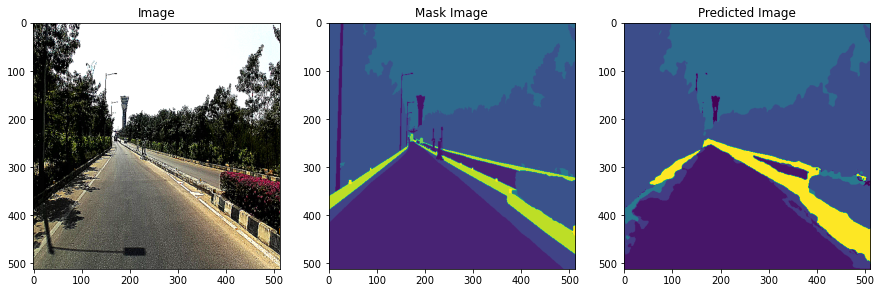

In [13]:

for i in range(10):
    image, mask = test_dataloader[i]

    mask_image = []
    for j in range(3):
        mask_image.append(np.argmax(mask[j], axis=-1))
        
    predicted_image = []
    for j in range(3):
        predicted = model.predict(np.expand_dims(image[j], 0))
        predicted_image.append(np.argmax(predicted[0], axis=-1))
        
    images = [image,mask_image,predicted_image]
    titles = ["Image", "Mask Image", "Predicted Image"]
    plt.figure(figsize=(15, 7))
    for j in range(3):
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(titles[i])
            plt.imshow(images[i][j])

# Task 3: Training CANet

In [11]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform, he_normal
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

C:\Users\paart\apps\lib\site-packages\keras\backend.py:401: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [12]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, filters=[4, 4, 8], stride=1, name="conv_block"):
        
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.strides = stride

        self.conv1 = Conv2D(self.F1, (1, 1), padding='same', kernel_initializer=he_normal())
        self.conv2 = Conv2D(self.F2, (3, 3), self.strides, padding='same', kernel_initializer=he_normal())
        self.conv3 = Conv2D(self.F3, (1, 1), padding='same', kernel_initializer=he_normal())
        self.res_block = Conv2D(self.F3, (3, 3), self.strides, padding='same', kernel_initializer=he_normal())
        
        self.batch_norm1 = BatchNormalization(axis=3)
        self.batch_norm2 = BatchNormalization(axis=3)
        self.batch_norm3 = BatchNormalization(axis=3)
        self.res_batch_norm4 = BatchNormalization()
        self.relu_activation = Activation('relu')
           

    def call(self, inp):

        conv1 = self.conv1(inp)
        conv1 = self.batch_norm1(conv1)
        conv1 = self.relu_activation(conv1)

        conv2 = self.conv2(conv1)
        conv2 = self.batch_norm2(conv2)
        conv2 = self.relu_activation(conv2)

        conv3 = self.conv3(conv2)
        conv3 = self.batch_norm3(conv3)
        
        res_block = self.res_block(inp)
        res_block = self.res_batch_norm4(res_block)
        res_block = self.relu_activation(res_block)

        c = add([res_block, conv3])
        c = self.relu_activation(c)

        return c
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

In [13]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, filters=[4, 4, 8], name="identity_block"):
        
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        
        self.conv1 = Conv2D(self.F1, (1, 1), padding='same', kernel_initializer=he_normal())
        self.conv2 = Conv2D(self.F2, (3, 3), padding='same', kernel_initializer=he_normal())
        self.conv3 = Conv2D(self.F3, (1, 1), padding='same', kernel_initializer=he_normal())
        
        self.batch_norm1 = BatchNormalization(axis=3)
        self.batch_norm2 = BatchNormalization(axis=3)
        self.batch_norm3 = BatchNormalization(axis=3)
        self.relu_activation = Activation('relu')

    def call(self, inp):

        conv1 = self.conv1(inp)
        conv1 = self.batch_norm1(conv1)
        conv1 = self.relu_activation(conv1)

        conv2 = self.conv2(conv1)
        conv2 = self.batch_norm2(conv2)
        conv2 = self.relu_activation(conv2)

        conv3 = self.conv3(conv2)
        conv3 = self.batch_norm3(conv3)

        i = add([conv3, inp])
        i = self.relu_activation(i)

        return i
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [14]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, kernel = 64, filters = 64, name="global_flow"):
        
        super().__init__(name=name)
        self.kernel = kernel
        self.filters = filters
        
        self.globalavgpool = GlobalAveragePooling2D()
        self.batch_norm = BatchNormalization(axis=3)
        self.conv = Conv2D(self.filters, (1,1), padding = 'same', kernel_initializer=he_normal())
        self.upsampling = UpSampling2D(size = (self.kernel,self.kernel), interpolation = 'bilinear')
        self.relu_activation = Activation('relu')
        self.reshape = Reshape((1,1,self.filters))
        
    def call(self, inp):

        gap = self.globalavgpool(inp)
        gapreshape = self.reshape(gap)
        batch_norm = self.batch_norm(gapreshape)
        batch_norm = self.relu_activation(batch_norm)
        conv = self.conv(batch_norm)
        upsampling = self.upsampling(conv)

        return upsampling
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

In [15]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, filters = 64, name="context_flow"):
        
        super().__init__(name=name)
        self.filters = filters
        
        self.avgpool = AveragePooling2D(strides = 2, padding = 'same')
        self.conv1 = Conv2D(self.filters, (3,3), padding = 'same', kernel_initializer=he_normal())
        self.conv2 = Conv2D(self.filters, (3,3), padding = 'same', kernel_initializer=he_normal())
        self.conv3 = Conv2D(self.filters, (1,1), padding = 'same', kernel_initializer=he_normal())
        self.conv4 = Conv2D(self.filters, (1,1), padding = 'same', kernel_initializer=he_normal())
        self.relu_activation = Activation('relu')
        self.sigmoid_activation = Activation('sigmoid')
        self.upsampling = UpSampling2D(size = (2,2), interpolation = 'bilinear')


    def call(self, inp):
        c4_input, global_input = inp[0], inp[1] 
        
        concat = concatenate([c4_input,global_input],axis=-1)
        avgpool = self.avgpool(concat)
        conv1 = self.conv1(avgpool)
        conv2 = self.conv2(conv1)
        
        conv3 = self.conv3(conv2)
        relu_activation = self.relu_activation(conv3)
        conv4 = self.conv4(relu_activation)
        sigmoid_activation = self.sigmoid_activation(conv4)

        conv2_sigmoid = multiply([conv2,sigmoid_activation])
        
        c = add([conv2,conv2_sigmoid])

        c = self.upsampling(c)
    
        return c
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [16]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self, name="fsm", filters = 32):
        
        super().__init__(name=name)
        self.filters = filters
        
        self.conv1 = Conv2D(filters, (3,3), padding = 'same', kernel_initializer=he_normal())
        self.conv2 = Conv2D(filters, (1,1), padding = 'same', kernel_initializer=he_normal())
        self.avgpool = GlobalAveragePooling2D()
        self.batch_norn = BatchNormalization(axis=3)
        self.upsampling = UpSampling2D(size = (2,2), interpolation = 'bilinear')
        self.sigmoid_activation = Activation('sigmoid')
        
    def call(self, inp):

        conv1 = self.conv1(inp)
        avgpool = self.avgpool(conv1)
        avgreshape = tf.keras.layers.Reshape((1,1,self.filters))(avgpool)
        conv2 = self.conv2(avgreshape)
        batch_norn = self.batch_norn(conv2)
        sigmoid_activation = self.sigmoid_activation(batch_norn)

        conv1_sigmoid = multiply([conv1,sigmoid_activation])

        upsampling = self.upsampling(conv1_sigmoid)

        return upsampling
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [17]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="agcn", filters = 32):
        super().__init__(name=name)
        self.filters = filters
        
        self.conv1 = Conv2D(self.filters, (7,1), padding = 'same', kernel_initializer=he_normal())
        self.conv2 = Conv2D(self.filters, (1,7), padding = 'same', kernel_initializer=he_normal())
        self.conv3 = Conv2D(self.filters, (1,7), padding = 'same', kernel_initializer=he_normal())
        self.conv4 = Conv2D(self.filters, (7,1), padding = 'same', kernel_initializer=he_normal())
        self.conv5 = Conv2D(self.filters, (3,3), padding = 'same', kernel_initializer=he_normal())
        
    def call(self, inp):

        conv1 = self.conv1(inp)
        conv2 = self.conv2(conv1)
        
        conv3 = self.conv3(inp)
        conv4 = self.conv4(conv3)
        
        conv2_conv4 = add([conv2,conv4])
        conv5 = self.conv5(conv2_conv4)
        
        agcn = add([conv2_conv4,conv5])

        return agcn
    
    def get_config(self):
        cfg = super().get_config()
        return cfg 

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [18]:
tf.keras.backend.clear_session()
X_input = Input(shape=(512, 512, 3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=he_normal(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

#C1
X = convolutional_block(filters=[4, 4, 8], stride=2, name='conv_block_1')(X)
C1 = identity_block(filters=[4, 4, 8], name='identity_block_1')(X)

#C2
X = convolutional_block(filters=[8, 8, 16], stride=2, name='conv_block_2')(C1)
X = identity_block(filters=[8, 8, 16], name='identity_block_2_1')(X)
X = identity_block(filters=[8, 8, 16], name='identity_block_2_2')(X)

#C3
X = convolutional_block(filters=[16, 16, 32], stride=1, name='conv_block_3')(X)
X = identity_block(filters=[16, 16, 32], name='identity_block_3_1')(X)
X = identity_block(filters=[16, 16, 32], name='identity_block_3_2')(X)
X = identity_block(filters=[16, 16, 32], name='identity_block_3_3')(X)

#C4
X = convolutional_block(filters=[32, 32, 64], stride=1, name='conv_block_4')(X)
X = identity_block(filters=[32, 32, 64], name='identity_block_4_1')(X)
X = identity_block(filters=[32, 32, 64], name='identity_block_4_2')(X)
X = identity_block(filters=[32, 32, 64], name='identity_block_4_3')(X)
X = identity_block(filters=[32, 32, 64], name='identity_block_4_4')(X)

#global flow
GF = global_flow(filters=64, name='global_flow')(X)

#context flow
CF1 = context_flow(filters=64, name='context_flow_1')([X, GF])
CF2 = context_flow(filters=64, name='context_flow_2')([X, CF1])
CF3 = context_flow(filters=64, name='context_flow_3')([X, CF2])

#add gf, cf
X = add([GF, CF1, CF2, CF3])

#fsm
X = fsm(filters=128)(X)

#agcn
agcn_ = agcn(filters=128)(C1)

X = concatenate([X, agcn_],axis=-1)

X = Conv2D(256, (3, 3), padding='same', activation = 'relu', kernel_initializer=he_normal())(X)
X = BatchNormalization()(X)
X = Conv2D(21, (3, 3), padding='same', activation = 'relu', kernel_initializer=he_normal())(X)
X = UpSampling2D(size=(4, 4), interpolation='bilinear')(X)
output = Activation('softmax')(X)


In [19]:
model = Model(inputs = X_input, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 512, 512, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           bn_conv1[0][0]                   
______________________________________________________________________________________________

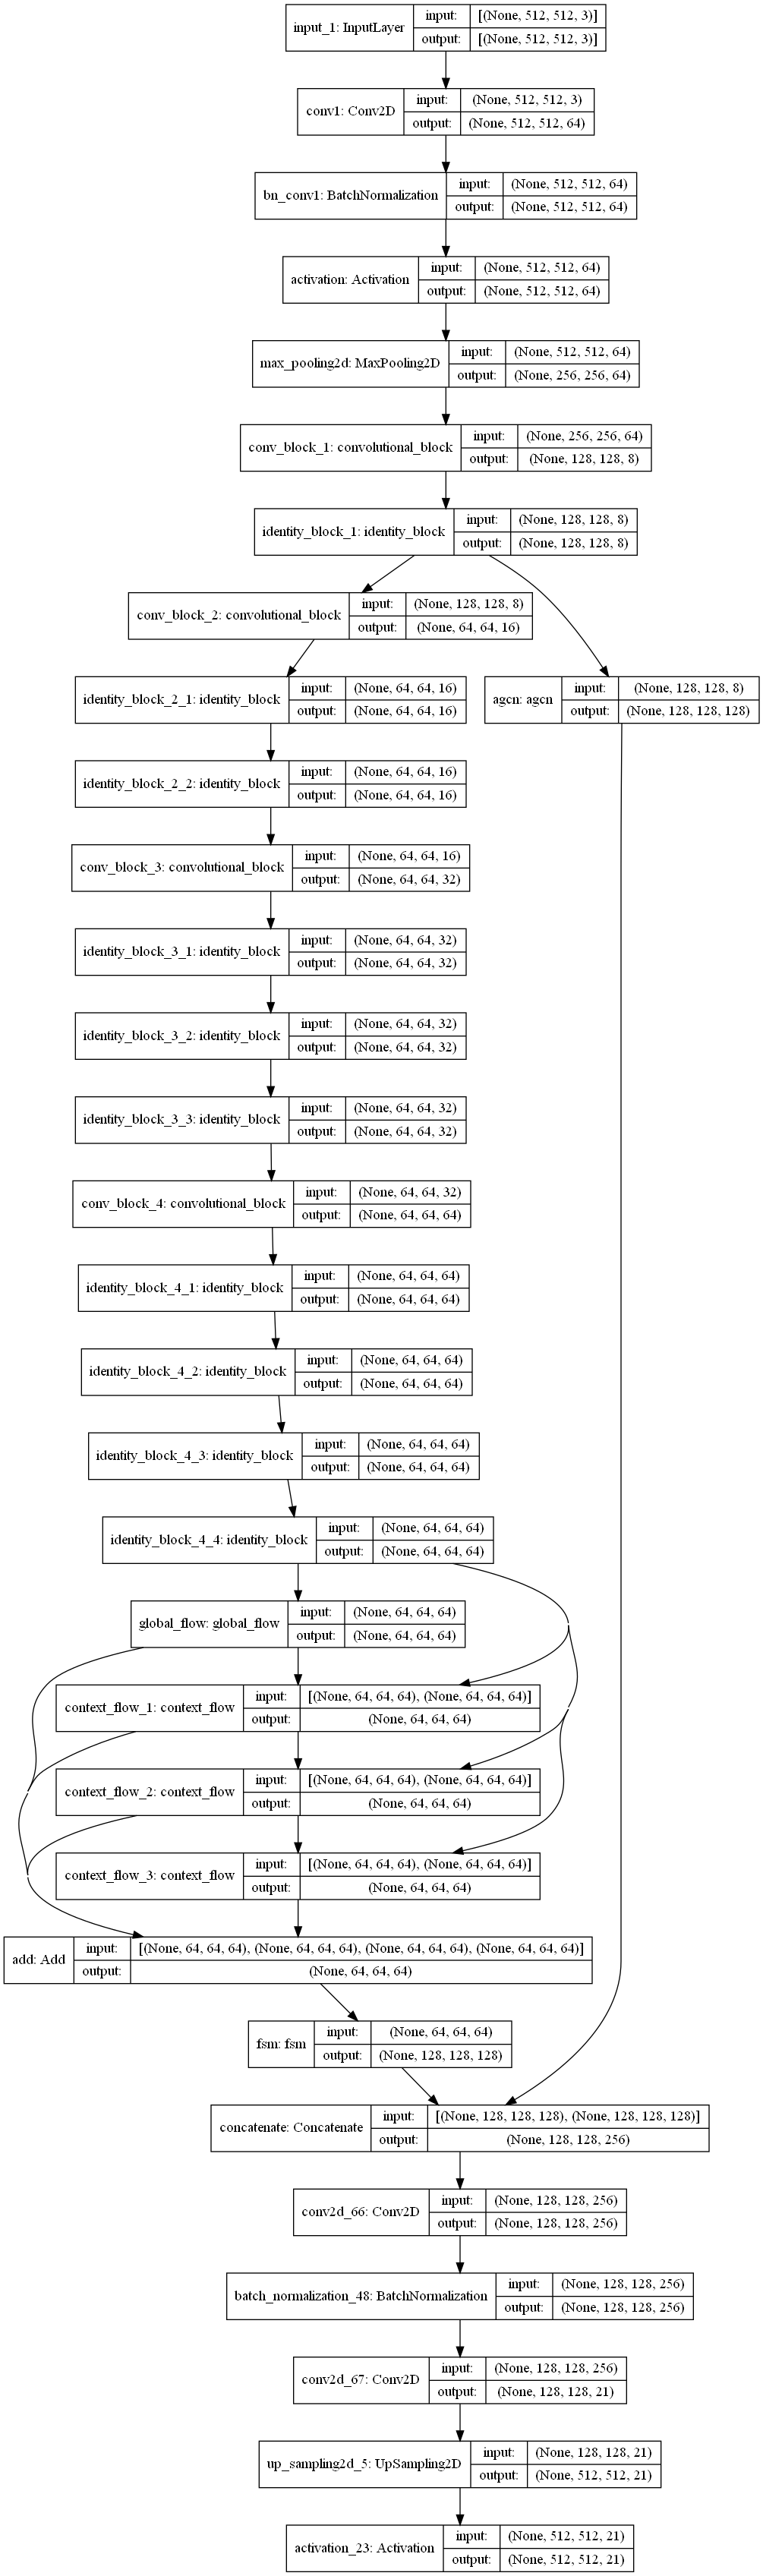

In [20]:
tf.keras.utils.plot_model(
    model, to_file='model2.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [21]:
import datetime

In [22]:
!rm -rf ./logs/canet/

In [23]:
log_dir="logs/canet/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=0, write_graph=True,write_grads=True)
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_iou_score', filepath = 'canetmodel.h5', save_best_only = True)

In [24]:
callbacks = [tensorboard_callback,modelcheckpoint]

In [25]:
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.0001)

#focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss 
total_loss = sm.losses.categorical_focal_dice_loss 

model.compile(optim, total_loss, metrics=[iou_score])

In [26]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

BATCH_SIZE=2

train_file_names = X_train.images.values
test_file_names = X_test.images.values
train_dataset = Dataset(X_train, label_clr, train_file_names)
test_dataset  = Dataset(X_test, label_clr, test_file_names)

train_dataloader = Dataloder(train_dataset, batch_size=3, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=3, shuffle=True)

In [27]:
len(train_dataloader)

1135

### Training CANet

In [28]:
model.fit_generator(train_dataloader, validation_data = test_dataloader, epochs = 15, steps_per_epoch = len(train_dataloader), callbacks = callbacks)

C:\Users\paart\apps\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
C:\Users\paart\apps\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/15
1135/1135 [==============================] - 710s 617ms/step - loss: 0.8523 - iou_score: 0.1264 - val_loss: 0.8380 - val_iou_score: 0.1416
Epoch 2/15
1135/1135 [==============================] - 702s 618ms/step - loss: 0.8036 - iou_score: 0.1645 - val_loss: 0.7999 - val_iou_score: 0.1720
Epoch 3/15
1135/1135 [==============================] - 697s 614ms/step - loss: 0.7855 - iou_score: 0.1788 - val_loss: 0.7895 - val_iou_score: 0.1785
Epoch 4/15
1135/1135 [==============================] - 685s 604ms/step - loss: 0.7670 - iou_score: 0.1943 - val_loss: 0.7632 - val_iou_score: 0.2018
Epoch 5/15
1135/1135 [==============================] - 703s 619ms/step - loss: 0.7547 - iou_score: 0.2048 - val_loss: 0.7648 - val_iou_score: 0.1978
Epoch 6/15
1135/1135 [==============================] - 695s 613ms/step - loss: 0.7484 - iou_score: 0.2089 - val_loss: 0.7528 - val_iou_score: 0.2096
Epoch 7/15
1135/1135 [==============================] - 698s 615ms/step - loss: 0.7360 - iou_score: 

In [ ]:
##using same model to train further using initial_epoch

In [29]:
model.fit_generator(train_dataloader, validation_data = test_dataloader, epochs = 25, initial_epoch = 15, steps_per_epoch = len(train_dataloader), callbacks = callbacks)

Epoch 16/25
1135/1135 [==============================] - 686s 604ms/step - loss: 0.6887 - iou_score: 0.2622 - val_loss: 0.6988 - val_iou_score: 0.2545
Epoch 17/25
1135/1135 [==============================] - 699s 616ms/step - loss: 0.6869 - iou_score: 0.2634 - val_loss: 0.6977 - val_iou_score: 0.2541
Epoch 18/25
1135/1135 [==============================] - 693s 611ms/step - loss: 0.7055 - iou_score: 0.2459 - val_loss: 0.7119 - val_iou_score: 0.2416
Epoch 19/25
1135/1135 [==============================] - 704s 620ms/step - loss: 0.6872 - iou_score: 0.2626 - val_loss: 0.6972 - val_iou_score: 0.2551
Epoch 20/25
1135/1135 [==============================] - 687s 605ms/step - loss: 0.6815 - iou_score: 0.2680 - val_loss: 0.6964 - val_iou_score: 0.2561
Epoch 21/25
1135/1135 [==============================] - 702s 619ms/step - loss: 0.6828 - iou_score: 0.2665 - val_loss: 0.6935 - val_iou_score: 0.2585
Epoch 22/25
1135/1135 [==============================] - 685s 604ms/step - loss: 0.6779 - iou_

In [30]:
model.fit_generator(train_dataloader, validation_data = test_dataloader, epochs = 35, initial_epoch = 25, steps_per_epoch = len(train_dataloader), callbacks = callbacks)

Epoch 26/35
1135/1135 [==============================] - 707s 623ms/step - loss: 0.6872 - iou_score: 0.2619 - val_loss: 0.6853 - val_iou_score: 0.2678
Epoch 27/35
1135/1135 [==============================] - 675s 595ms/step - loss: 0.6690 - iou_score: 0.2784 - val_loss: 0.6732 - val_iou_score: 0.2766
Epoch 28/35
1135/1135 [==============================] - 694s 611ms/step - loss: 0.6629 - iou_score: 0.2847 - val_loss: 0.6710 - val_iou_score: 0.2787
Epoch 29/35
1135/1135 [==============================] - 708s 624ms/step - loss: 0.6632 - iou_score: 0.2848 - val_loss: 0.6662 - val_iou_score: 0.2846
Epoch 30/35
1135/1135 [==============================] - 701s 617ms/step - loss: 0.6631 - iou_score: 0.2847 - val_loss: 0.6863 - val_iou_score: 0.2680
Epoch 31/35
1135/1135 [==============================] - 677s 596ms/step - loss: 0.6573 - iou_score: 0.2909 - val_loss: 0.6726 - val_iou_score: 0.2790
Epoch 32/35
1135/1135 [==============================] - 699s 616ms/step - loss: 0.6570 - iou_

In [ ]:
%tensorboard --logdir="C:\Users\paart\segmentation\logs\canet\20220815-224452"

### Predicting on test image

<ipython-input-46-27c68221b52d>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1, 3, i + 1)


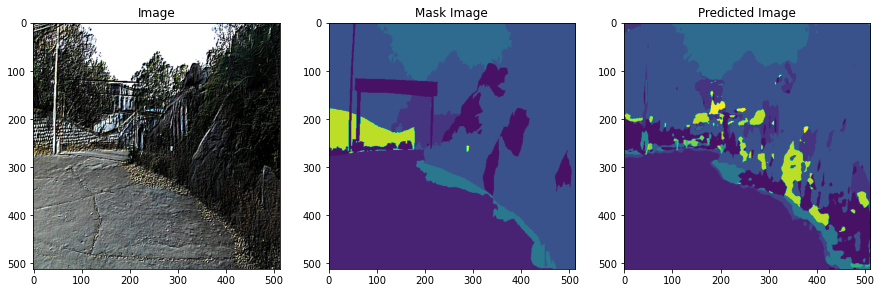

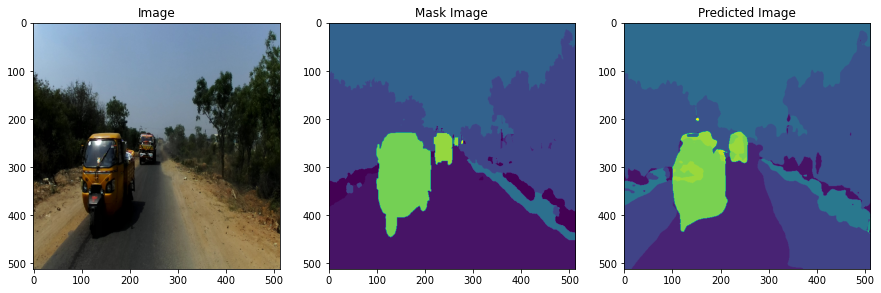

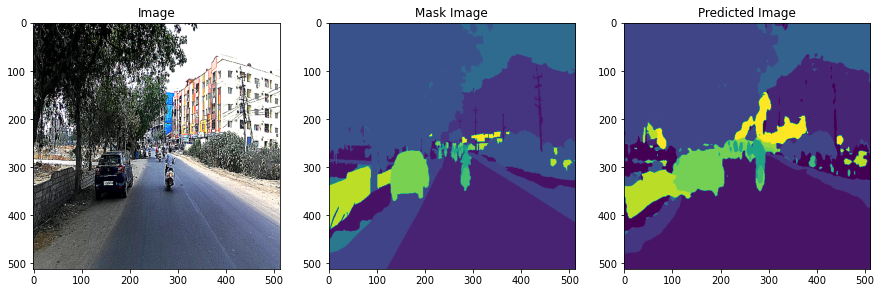

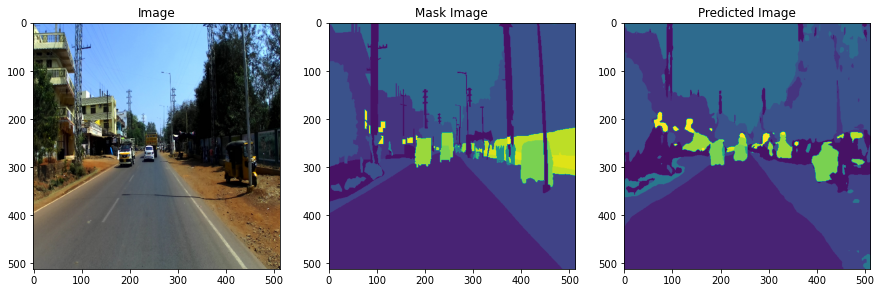

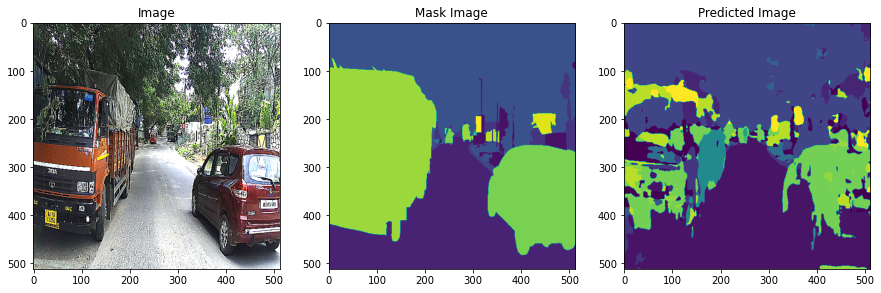

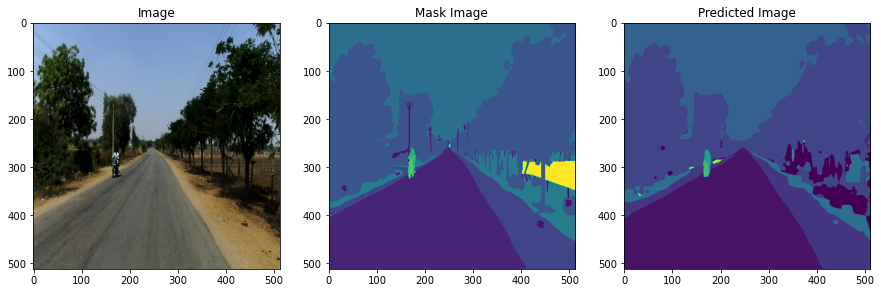

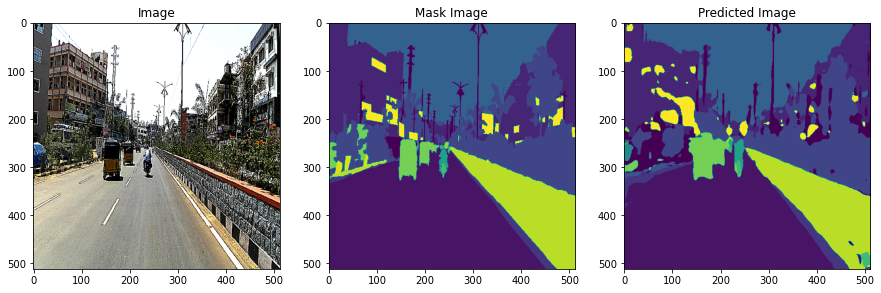

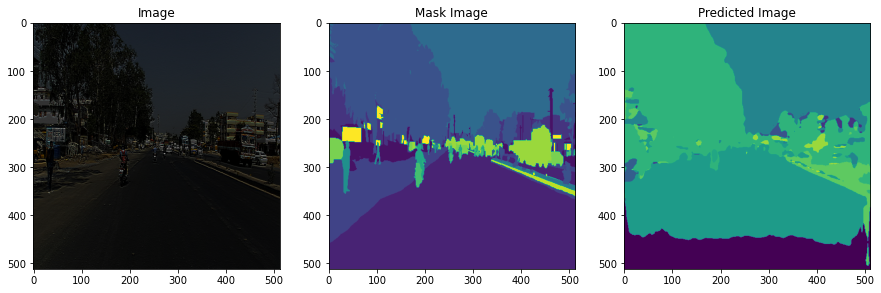

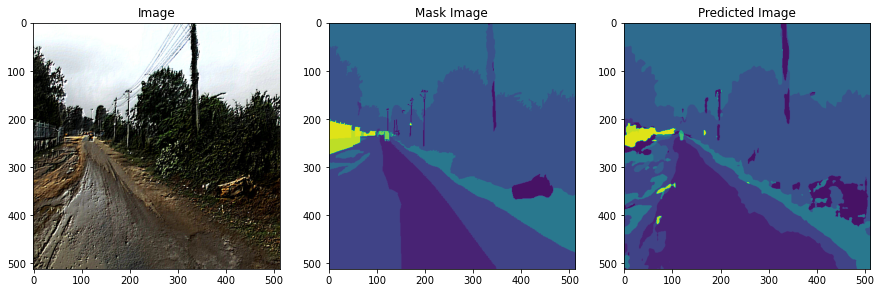

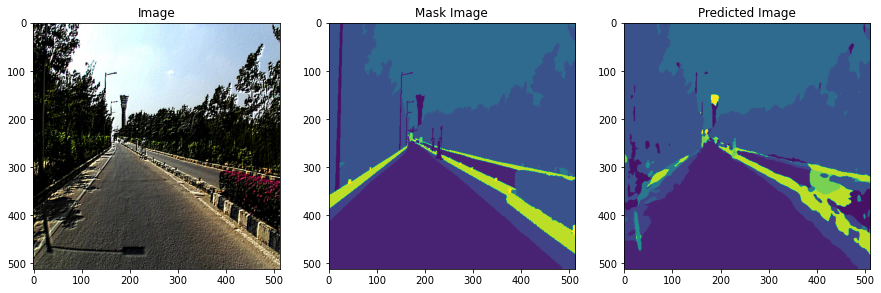

In [46]:

for i in range(10):
    image, mask = test_dataloader[i]

    mask_image = []
    for j in range(3):
        mask_image.append(np.argmax(mask[j], axis=-1))
        
    predicted_image = []
    for j in range(3):
        predicted = model.predict(np.expand_dims(image[j], 0))
        predicted_image.append(np.argmax(predicted[0], axis=-1))
        
    images = [image,mask_image,predicted_image]
    titles = ["Image", "Mask Image", "Predicted Image"]
    plt.figure(figsize=(15, 7))
    for j in range(3):
        for i in range(3):
            plt.subplot(1, 3, i + 1)
            plt.title(titles[i])
            plt.imshow(images[i][j])

## summary on unet

`I haven't added graph for loss and iou, as my tensorboard couldn't load at that time. I tried it through cmd also, it is not loading, but the data is available inside that mentioned path`

1. After epoch 38 the model seems to stop learning much:
- loss: 0.3722 
- iou_score: 0.5889 
- val_loss: 0.4284 
- val_iou_score: 0.5367

2. Achieved highest iou score at epoch 49: 
- loss: 0.3575 
- iou_score: 0.6084 
- val_loss: 0.4244 
- val_iou_score: 0.5417

3. The model is not much improving after epoch 35
4. prediction on test data works little good, but couldn't exactly predict all pixels
5. in this model, it is labelling the nearest pixel for an object as same. for example, where there is vehicle it couldn't identify shape of that vehicle better, whereas it labels vehicles nearest pixels alse the same

## summary on CANet

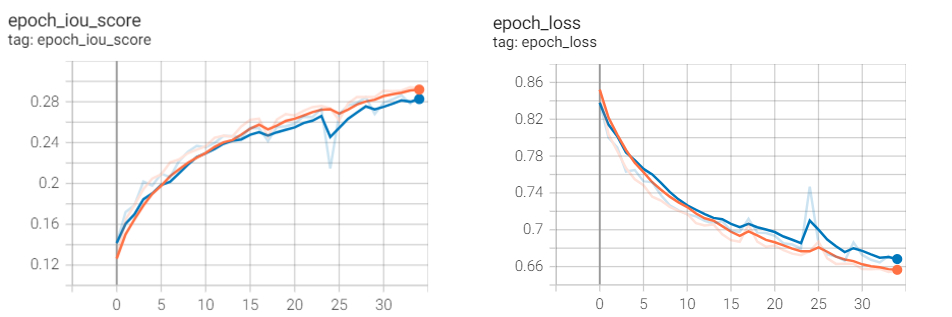

1. Achived iou_score: 0.2932
2. But in unet we achived over 0.58 for same num of epoch
3. performace of canet is better than unet eventhough iou is less
4. for the above point, we can see for canet model with same example, the vehicles pixels are labelled more properly and 
   we can see the shape of vehicle is more properly predicted than unet